# Fit CoFactor model

In [1]:
import itertools
import glob
import os
import sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from scipy import sparse
import seaborn as sns
sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [22]:
import cofacto
import rec_eval

### Construct the positive pairwise mutual information (PPMI) matrix

Change this to wherever you saved the pre-processed data following [this notebook](./preprocess_ML20M.ipynb).

In [23]:
DATA_DIR = '/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro'

In [24]:
unique_uid = list()
with open(os.path.join(DATA_DIR, 'unique_uid.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [25]:
unique_sid

['1-1-1-1',
 '1-1-12-12',
 '1-1-13-13',
 '1-1-14-14',
 '1-1-15-15',
 '1-1-18-10',
 '1-1-18-16',
 '1-1-18-17',
 '1-1-18-18',
 '1-1-18-20',
 '1-1-18-32',
 '1-1-18-33',
 '1-1-19-19',
 '1-1-2-2',
 '1-1-3-3',
 '1-1-30-30',
 '1-1-32-24',
 '1-1-4-4',
 '1-1-5-31',
 '1-1-6-5',
 '1-1-7-7',
 '1-1-8-6',
 '1-1-9-9',
 '1-11-12-12',
 '1-11-13-11',
 '1-11-13-13',
 '1-11-13-14',
 '1-11-13-15',
 '1-11-3-1',
 '1-11-3-2',
 '1-11-3-27',
 '1-11-3-28',
 '1-11-3-3',
 '1-11-3-9',
 '1-11-4-30',
 '1-11-5-16',
 '1-11-5-24',
 '1-11-5-4',
 '1-11-5-5',
 '1-11-6-6',
 '1-11-8-10',
 '1-11-8-22',
 '1-11-8-8',
 '1-12-1-10',
 '1-12-1-11',
 '1-12-1-12',
 '1-12-1-14',
 '1-12-1-9',
 '1-12-17-17',
 '1-12-17-2',
 '1-12-17-4',
 '1-12-17-7',
 '1-12-17-8',
 '1-12-18-18',
 '1-12-2-41',
 '1-12-3-13',
 '1-12-3-15',
 '1-12-3-24',
 '1-12-3-25',
 '1-12-3-3',
 '1-12-3-40',
 '1-12-4-42',
 '1-12-5-5',
 '1-15-1-1',
 '1-15-10-10',
 '1-15-11-2',
 '1-15-11-4',
 '1-15-12-12',
 '1-15-5-5',
 '1-15-8-8',
 '1-15-9-9',
 '1-17-1-1',
 '1-17-1-3',
 '1

In [26]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print(n_users, n_items)

15413 2036


In [27]:
raw_train_data=pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

In [28]:
raw_train_data.head()

,timestamp,uid,sid
0,1517596500,13282,377
1,1517598960,6722,1180
2,1517598960,6722,1277
3,1517598960,6722,1187
4,1517599020,14270,1303


In [29]:
raw_train_data['userstamp']=raw_train_data['timestamp'].map(str)+'-'+raw_train_data['uid'].map(str)

In [30]:
raw_train_data.head()

,timestamp,uid,sid,userstamp
0,1517596500,13282,377,1517596500-13282
1,1517598960,6722,1180,1517598960-6722
2,1517598960,6722,1277,1517598960-6722
3,1517598960,6722,1187,1517598960-6722
4,1517599020,14270,1303,1517599020-14270


In [31]:
unique_userstamp=np.unique(raw_train_data['userstamp'])

In [32]:
unique_userstamp=pd.DataFrame(unique_userstamp)

In [33]:
unique_userstamp['idx']=unique_userstamp.index

In [34]:
unique_userstamp.columns=['userstamp', 'idx']

In [35]:
unique_userstamp.head()

,userstamp,idx
0,1517596500-13282,0
1,1517598960-6722,1
2,1517599020-14270,2
3,1517599080-13568,3
4,1517599140-13926,4


In [36]:
raw_train_data=pd.merge(raw_train_data,unique_userstamp,on='userstamp')

In [37]:
raw_train_data.head()

,timestamp,uid,sid,userstamp,idx
0,1517596500,13282,377,1517596500-13282,0
1,1517598960,6722,1180,1517598960-6722,1
2,1517598960,6722,1277,1517598960-6722,1
3,1517598960,6722,1187,1517598960-6722,1
4,1517599020,14270,1303,1517599020-14270,2


In [38]:
raw_train_data.to_csv('/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/new_train.csv')

In [39]:
n_users

15413

In [40]:
n_users=max(raw_train_data.idx)+1

In [41]:
def load_data(csv_file, shape=(n_users, n_items)):
    tp = pd.read_csv(csv_file)
    timestamps, rows, cols = np.array(tp['timestamp']), np.array(tp['idx']), np.array(tp['sid'])
    seq = np.concatenate((rows[:, None], cols[:, None], np.ones((rows.size, 1), dtype='int'), timestamps[:, None]), axis=1)
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int16, shape=shape)
    return data, seq

In [42]:
train_data, train_raw = load_data(os.path.join(DATA_DIR, 'new_train.csv'))

In [43]:
print(train_data)

  (0, 377)	1
  (1, 1180)	1
  (1, 1187)	1
  (1, 1277)	1
  (2, 1303)	1
  (2, 1305)	1
  (3, 1243)	1
  (3, 1501)	1
  (4, 126)	1
  (4, 143)	1
  (4, 853)	1
  (4, 1298)	1
  (5, 247)	1
  (6, 113)	1
  (6, 130)	1
  (6, 460)	1
  (6, 507)	1
  (6, 508)	1
  (6, 1072)	1
  (7, 1336)	1
  (8, 1160)	1
  (8, 1407)	1
  (9, 126)	1
  (9, 127)	2
  (9, 1383)	1
  :	:
  (386139, 2035)	1
  (386140, 162)	1
  (386140, 215)	1
  (386140, 226)	1
  (386140, 385)	1
  (386140, 699)	1
  (386141, 1662)	1
  (386142, 1374)	1
  (386143, 143)	1
  (386144, 898)	1
  (386144, 1028)	1
  (386144, 1662)	1
  (386145, 1271)	1
  (386145, 1278)	1
  (386146, 21)	1
  (386146, 154)	1
  (386146, 160)	1
  (386146, 227)	1
  (386146, 507)	1
  (386146, 770)	1
  (386146, 1120)	1
  (386146, 1294)	1
  (386146, 1849)	1
  (386146, 1995)	1
  (386147, 1641)	1


In [44]:
train_raw

array([[         0,        377,          1, 1517596500],
       [         1,       1180,          1, 1517598960],
       [         1,       1277,          1, 1517598960],
       ...,
       [    386145,       1271,          1, 1543059960],
       [    386145,       1278,          1, 1543059960],
       [    386147,       1641,          1, 1543060020]])

In [45]:
purchase_per_item = np.asarray(train_data.astype('int64').sum(axis=0)).ravel()

In [46]:
len(purchase_per_item)

2036

In [47]:
print("The mean (median)  per item is %d (%d)" % (purchase_per_item.mean(), np.median(purchase_per_item)))

The mean (median)  per item is 538 (130)


In [48]:
userstamp_activity = np.asarray(train_data.sum(axis=1)).ravel()

In [49]:
user_activity = np.asarray(train_data.sum(axis=1)).ravel()

In [50]:
np.unique(userstamp_activity,return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 50, 52, 54, 58]),
 array([132525,  95439,  59592,  35965,  21874,  13672,   8463,   5520,
          3829,   2510,   1756,   1253,    919,    685,    480,    375,
           294,    226,    170,    112,    104,     61,     60,     47,
            49,     24,     25,     20,     17,      8,     16,      8,
             6,      5,      4,      6,      5,      4,      4,      3,
             1,      1,      1,      2,      1,      1,      3,      1,
             1,      1]))

In [51]:
print("The mean (median) items each user purchased in one transaction is %d (%d)" % (userstamp_activity.mean(), np.median(userstamp_activity)))



The mean (median) items each user purchased in one transaction is 2 (2)


In [52]:
n_items = len(unique_sid)
n_users = len(unique_uid)

print(n_users, n_items)

15413 2036


In [53]:
def load_vad_data(csv_file, shape=(n_users, n_items)):
    tp = pd.read_csv(csv_file)
    timestamps, rows, cols = np.array(tp['timestamp']), np.array(tp['uid']), np.array(tp['sid'])
    seq = np.concatenate((rows[:, None], cols[:, None], np.ones((rows.size, 1), dtype='int'), timestamps[:, None]), axis=1)
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int16, shape=shape)
    return data, seq

In [54]:
vad_data, vad_raw = load_vad_data(os.path.join(DATA_DIR, 'validation.csv'))

In [55]:
n_userstamp=max(raw_train_data.idx)+1

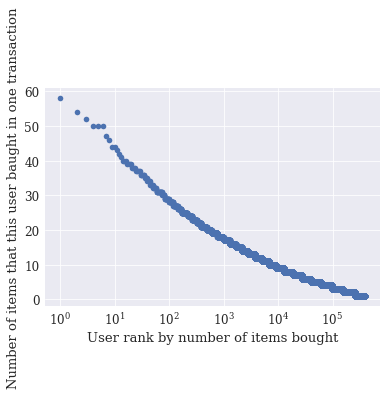

In [56]:
plt.semilogx(1 + np.arange(n_userstamp), -np.sort(-userstamp_activity), 'o')
plt.ylabel('Number of items that this user baught in one transaction')
plt.xlabel('User rank by number of items bought')
pass

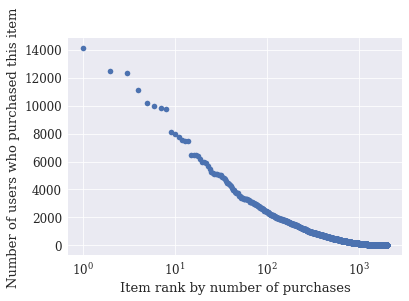

In [57]:
plt.semilogx(1 + np.arange(n_items), -np.sort(-purchase_per_item), 'o')
plt.ylabel('Number of users who purchased this item')
plt.xlabel('Item rank by number of purchases')
pass

### Generate co-occurrence matrix based on items bought in single transaction

In [823]:
train_raw

array([[         0,        377,          1, 1517596500],
       [         1,       1180,          1, 1517598960],
       [         1,       1277,          1, 1517598960],
       ...,
       [    386145,       1271,          1, 1543059960],
       [    386145,       1278,          1, 1543059960],
       [    386147,       1641,          1, 1543060020]])

In [58]:
OP_DIR = '/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Trans_Based'

In [59]:
def _coord_batch(lo, hi, train_data):
    rows = []
    cols = []
    for u in range(lo, hi):
        for w, c in itertools.permutations(train_data[u].nonzero()[1], 2):
            rows.append(w)
            cols.append(c)
    np.save(os.path.join(OP_DIR, 'coo_%d_%d.npy' % (lo, hi)),
            np.concatenate([np.array(rows)[:, None], np.array(cols)[:, None]], axis=1))
    pass

In [60]:
from joblib import Parallel, delayed

batch_size = 5000

start_idx = range(0, n_userstamp, batch_size)
end_idx = list(start_idx[1:]) + [n_userstamp]

Parallel(n_jobs=8)(delayed(_coord_batch)(lo, hi, train_data) for lo, hi in zip(start_idx, end_idx))
pass

In [61]:
X = sparse.csr_matrix((n_items, n_items), dtype='float32')

for lo, hi in zip(start_idx, end_idx):
    coords = np.load(os.path.join(OP_DIR, 'coo_%d_%d.npy' % (lo, hi)))
    
    rows = coords[:, 0]
    cols = coords[:, 1]
    
    tmp = sparse.coo_matrix((np.ones_like(rows), (rows, cols)), shape=(n_items, n_items), dtype='float32').tocsr()
    X = X + tmp
    
    print("User %d to %d finished" % (lo, hi))
    sys.stdout.flush()

User 0 to 5000 finished
User 5000 to 10000 finished
User 10000 to 15000 finished
User 15000 to 20000 finished
User 20000 to 25000 finished
User 25000 to 30000 finished
User 30000 to 35000 finished
User 35000 to 40000 finished
User 40000 to 45000 finished
User 45000 to 50000 finished
User 50000 to 55000 finished
User 55000 to 60000 finished
User 60000 to 65000 finished
User 65000 to 70000 finished
User 70000 to 75000 finished
User 75000 to 80000 finished
User 80000 to 85000 finished
User 85000 to 90000 finished
User 90000 to 95000 finished
User 95000 to 100000 finished
User 100000 to 105000 finished
User 105000 to 110000 finished
User 110000 to 115000 finished
User 115000 to 120000 finished
User 120000 to 125000 finished
User 125000 to 130000 finished
User 130000 to 135000 finished
User 135000 to 140000 finished
User 140000 to 145000 finished
User 145000 to 150000 finished
User 150000 to 155000 finished
User 155000 to 160000 finished
User 160000 to 165000 finished
User 165000 to 170000 

Note: Don't forget to delete all the temporary coo_LO_HI.npy files

In [62]:
np.save(os.path.join(OP_DIR, 'coordinate_trans_co_binary_data.npy'), X.data)
np.save(os.path.join(OP_DIR, 'coordinate_trans_co_binary_indices.npy'), X.indices)
np.save(os.path.join(OP_DIR, 'coordinate_trans_co_binary_indptr.npy'), X.indptr)

In [63]:
1-float(X.nnz) / np.prod(X.shape)

0.8289376681423957

### Or load the pre-saved co-occurrence matrix

In [64]:
# or co-occurrence matrix from the entire user history
dir_predix = OP_DIR

In [65]:
data = np.load(os.path.join(dir_predix, 'coordinate_trans_co_binary_data.npy'))
indices = np.load(os.path.join(dir_predix, 'coordinate_trans_co_binary_indices.npy'))
indptr = np.load(os.path.join(dir_predix, 'coordinate_trans_co_binary_indptr.npy'))

In [66]:
X = sparse.csr_matrix((data, indices, indptr), shape=(n_items, n_items))

In [67]:
print(X.shape)

(2036, 2036)


In [68]:
1-float(X.nnz) / np.prod(X.shape)

0.8289376681423957

In [69]:
def get_row(Y, i):
    lo, hi = Y.indptr[i], Y.indptr[i + 1]
    return lo, hi, Y.data[lo:hi], Y.indices[lo:hi]

In [70]:
count = np.asarray(X.sum(axis=1)).ravel()

In [71]:
count

array([15213.,  7669.,  9229., ...,    26.,    32.,  3241.], dtype=float32)

In [72]:
n_pairs = X.data.sum()

In [73]:
n_pairs

3196248.0

### Construct the SPPMI matrix

In [74]:
M = X.copy()

for i in range(n_items):
    lo, hi, d, idx = get_row(M, i)
    M.data[lo:hi] = np.log(d * n_pairs / (count[i] * count[idx]))

In [75]:
M.data[M.data < 0] = 0
M.eliminate_zeros()

In [76]:
1-float(M.nnz) / np.prod(M.shape)

0.8877720674229295

Now $M$ is the PPMI matrix. Depending on the number of negative examples $k$, we can obtain the shifted PPMI matrix as $\max(M_{wc} - \log k, 0)$

In [77]:
# number of negative samples
k_ns = 1

M_ns = M.copy()

if k_ns > 1:
    offset = np.log(k_ns)
else:
    offset = 0.
    
M_ns.data -= offset
M_ns.data[M_ns.data < 0] = 0
M_ns.eliminate_zeros()

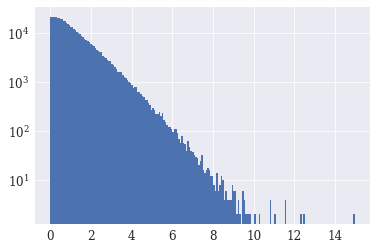

In [78]:
plt.hist(M_ns.data, bins=200)
plt.yscale('log')
pass

In [79]:
1-float(M_ns.nnz) / np.prod(M_ns.shape)

0.8877720674229295

In [80]:
M_ns.A

array([[0.        , 0.82148165, 0.507936  , ..., 2.0894861 , 0.        ,
        0.        ],
       [0.82148165, 0.        , 0.30363807, ..., 0.        , 0.        ,
        0.        ],
       [0.507936  , 0.30363807, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.0894861 , 0.        , 0.        , ..., 0.        , 8.253655  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 8.253655  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

### Train the model

In [81]:
scale = 0.03

n_components = 100
max_iter = 20
n_jobs = 8
lam_theta = lam_beta = 1e-5 * scale
lam_gamma = 1e-5
c0 = 1. * scale
c1 = 10. * scale

save_dir = os.path.join(OP_DIR, 'ML20M_ns%d_scale%1.2E' % (k_ns, scale))

In [82]:
train_data, train_raw = load_vad_data(os.path.join(DATA_DIR, 'train.csv'))

In [83]:
import cofacto
coder = cofacto.CoFacto(n_components=n_components, max_iter=max_iter, batch_size=1000, init_std=0.01, n_jobs=n_jobs, 
                        random_state=98765, save_params=True, save_dir=save_dir, early_stopping=True, verbose=True, 
                        lam_theta=lam_theta, lam_beta=lam_beta, lam_gamma=lam_gamma, c0=c0, c1=c1)

In [859]:
print(train_data)

  (0, 28)	1
  (0, 167)	4
  (0, 176)	1
  (0, 215)	1
  (0, 221)	1
  (0, 236)	1
  (0, 396)	1
  (0, 422)	1
  (0, 426)	1
  (0, 616)	1
  (0, 1211)	2
  (0, 1248)	1
  (0, 1258)	1
  (0, 1294)	1
  (0, 1303)	1
  (0, 1614)	1
  (0, 1641)	2
  (0, 1726)	2
  (0, 1934)	3
  (0, 1954)	1
  (1, 1)	1
  (1, 68)	1
  (1, 73)	1
  (1, 126)	1
  (1, 157)	1
  :	:
  (15412, 581)	1
  (15412, 588)	1
  (15412, 614)	2
  (15412, 619)	2
  (15412, 623)	1
  (15412, 762)	1
  (15412, 1058)	1
  (15412, 1067)	1
  (15412, 1152)	1
  (15412, 1166)	3
  (15412, 1264)	1
  (15412, 1271)	10
  (15412, 1276)	1
  (15412, 1285)	1
  (15412, 1638)	1
  (15412, 1641)	1
  (15412, 1726)	1
  (15412, 1757)	1
  (15412, 1776)	1
  (15412, 1800)	1
  (15412, 1878)	2
  (15412, 1915)	1
  (15412, 1984)	1
  (15412, 1992)	1
  (15412, 2000)	1


In [84]:
np.savetxt('/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Trans_Based/trans_coo_mat.csv',M_ns.A)

In [85]:
coder.fit(train_data, M_ns, vad_data=vad_data, batch_users=5000, k=100)

ITERATION #0
	Updating user factors: time=0.88
	Updating item factors: time=0.48
	Updating context factors: time=0.25
	Updating bias terms: time=0.21


/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


	Validation NDCG@k: 0.04280
ITERATION #1
	Updating user factors: time=0.62
	Updating item factors: time=0.47
	Updating context factors: time=0.26
	Updating bias terms: time=0.21
	Validation NDCG@k: 0.06211
ITERATION #2
	Updating user factors: time=0.63
	Updating item factors: time=0.47
	Updating context factors: time=0.26
	Updating bias terms: time=0.21
	Validation NDCG@k: 0.06850
ITERATION #3
	Updating user factors: time=0.59
	Updating item factors: time=0.45
	Updating context factors: time=0.26
	Updating bias terms: time=0.23
	Validation NDCG@k: 0.07034
ITERATION #4
	Updating user factors: time=0.65
	Updating item factors: time=0.71
	Updating context factors: time=0.31
	Updating bias terms: time=0.22
	Validation NDCG@k: 0.07053
ITERATION #5
	Updating user factors: time=0.61
	Updating item factors: time=0.58
	Updating context factors: time=0.26
	Updating bias terms: time=0.25
	Validation NDCG@k: 0.07114
ITERATION #6
	Updating user factors: time=0.60
	Updating item factors: time=0.48
	

CoFacto(batch_size=1000, dtype='float32', early_stopping=True, init_std=0.01,
    max_iter=20, n_components=100, n_jobs=8, random_state=98765,
    save_dir='/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/data/pro/Trans_Based/ML20M_ns1_scale3.00E-02',
    save_params=True, verbose=True)

In [86]:
test_data, _ = load_vad_data(os.path.join(DATA_DIR, 'test.csv'))
test_data.data = np.ones_like(test_data.data)

In [87]:
n_params = len(glob.glob(os.path.join(save_dir, '*.npz')))

params = np.load(os.path.join(save_dir, 'CoFacto_K%d_iter%d.npz' % (n_components, n_params - 1)))
U, V = params['U'], params['V']

In [88]:
U.shape

(15413, 100)

In [89]:
V.shape

(2036, 100)

In [90]:
print('Test Recall@20: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=20, vad_data=vad_data))
print('Test Recall@50: %.4f' % rec_eval.recall_at_k(train_data, test_data, U, V, k=50, vad_data=vad_data))
print('Test NDCG@100: %.4f' % rec_eval.normalized_dcg_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))
print('Test MAP@100: %.4f' % rec_eval.map_at_k(train_data, test_data, U, V, k=100, vad_data=vad_data))

/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:184: RuntimeWarning: invalid value encountered in true_divide
  recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))


Test Recall@20: 0.0482
Test Recall@50: 0.0891


/Users/hr250012/OneDrive - Teradata/Documents/CVS/Solution/code/rec_eval.py:257: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG


Test NDCG@100: 0.0822
Test MAP@100: 0.0155


In [91]:
np.savez('CoFactor_K100_ML20M.npz', U=U, V=V)

In [92]:
R=U.dot(V.T)

In [93]:
R.shape

(15413, 2036)

In [94]:
R.min()

-21.067617

In [95]:
R.max()

480.37238

In [96]:
train_data.shape

(15413, 2036)

In [97]:
seg2id = dict((sid, i) for (i, sid) in enumerate(unique_sid)) 
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [98]:
id2seg = dict((i, sid) for (i, sid) in enumerate(unique_sid))
id2user = dict((i, uid) for (i, uid) in enumerate(unique_uid))

In [99]:
V

array([[-0.0427846 , -0.08869379,  0.03793289, ...,  0.04691526,
         0.00926645,  0.05508937],
       [-0.03723167, -0.0119346 ,  0.0071932 , ...,  0.03553908,
        -0.00154484, -0.01196469],
       [-0.06916848, -0.00600162, -0.02964898, ..., -0.02877216,
         0.00250859, -0.02954924],
       ...,
       [ 0.01720364,  0.01207156,  0.00576961, ..., -0.00084828,
         0.00190422, -0.00203173],
       [ 0.0266694 ,  0.01959181,  0.00979557, ..., -0.00122377,
         0.00286945, -0.00349925],
       [ 0.00415552, -0.00057849,  0.02128688, ..., -0.00754159,
        -0.03942587, -0.00886947]], dtype=float32)

In [115]:
from sklearn.preprocessing import MinMaxScaler  

In [116]:

#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------
def recommend(original_user_id, data_sparse, user_vecs, item_vecs, user2id, seg2id, id2user, id2seg, num_items=10):
    """Recommend items for a given user given a trained model

    Args:
    user_id (int): The id of the user we want to create recommendations for.

    data_sparse (csr_matrix): Our original training data.

    user_vecs (csr_matrix): The trained user x features vectors

    item_vecs (csr_matrix): The trained item x features vectors

    id2seg (dictionary): Used to map ids to segment names

    num_items (int): How many recommendations we want to return:

    Returns:
    recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores

    """
    user_id = user2id[str(original_user_id)]
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()
 
    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    user_interactions[user_interactions > 1] = 0
 
    # This is where we calculate the recommendation by taking the
    # dot-product of the user vectors with the item vectors.
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T)
 
    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = rec_vector_scaled
 
    # Get all the segments indices in order of recommendations (descending) and
    # select only the top "num_items" items.
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]
 
    top_n_recommended_items = []
    item_scores = []
 
    # Loop through our recommended segments indicies and look up the actial artist name
    top_n_recommended_items = list(map(lambda x: id2seg[x], item_idx))
    top_n_recommended_items
 

    for item_id in item_idx:
        item_scores.append(recommend_vector[item_id])
 
    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'items': top_n_recommended_items, 'score': item_scores})
 
    return recommendations.sort_values(['score'], ascending=[False])
 



In [123]:
recommendations = recommend(15,train_data,U,V,user2id,seg2id,id2user,id2seg,15)
recommendations

,items,score
0,5-41-1-1,1.000000
1,2-80-4-19,0.957837
2,4-35-3-41,0.475371
3,7-4-1-5,0.471421
4,4-35-3-44,0.440276
5,1-17-17-17,0.418885
6,2-13-4-28,0.416322
7,5-41-41-43,0.410331
8,7-71-6-2,0.408648
9,1-87-4-12,0.398154


In [124]:
user2id['15']

2

In [125]:
items=test_data.A[2].nonzero()

In [126]:
print(items)

(array([ 578,  853, 1303, 1662, 1788, 1790]),)


In [127]:
test_i=np.array(list((map(lambda x: id2seg[x], np.array(items[0])))))

In [128]:
print(test_i.reshape(-1,1))

[['2-80-4-19']
 ['3-36-12-13']
 ['4-35-3-41']
 ['5-41-1-1']
 ['7-16-10-11']
 ['7-16-2-2']]


In [129]:
recommendations

,items,score
0,5-41-1-1,1.000000
1,2-80-4-19,0.957837
2,4-35-3-41,0.475371
3,7-4-1-5,0.471421
4,4-35-3-44,0.440276
5,1-17-17-17,0.418885
6,2-13-4-28,0.416322
7,5-41-41-43,0.410331
8,7-71-6-2,0.408648
9,1-87-4-12,0.398154


In [130]:
#------------------------------
# FIND SIMILAR ITEMS
#------------------------------
def get_similar_items(item_id, number_of_similar_items, U, V, id2user, id2seg):
    item_vecs = V
 
    item_id = item_id
 
    # Get the item row for item_id
    item_vec = item_vecs[item_id].T
 
    n = number_of_similar_items
    # Calculate the similarity score between item_id  and other items
    # and select the top n most similar.
    scores = item_vecs.dot(item_vec).reshape(1,-1)[0]
    top_10 = np.argsort(scores)[::-1][:n]
 
    items = []
    item_scores = []
 
    top_10_similar_items = list(map(lambda x: id2seg[x], top_10))
    top_10_similar_items
 
    for item_id in top_10:
        item_scores.append(scores[item_id])
 
    similar = pd.DataFrame({'items': top_10_similar_items, 'item_score': item_scores})
 
    return similar

In [133]:
items_similar_to_id_1 = get_similar_items(1,15,U,V,id2user,id2seg)

In [134]:
items_similar_to_id_1

,items,item_score
0,1-1-12-12,0.090274
1,4-32-2-13,0.080848
2,3-21-2-2,0.066771
3,7-14-5-31,0.061569
4,4-35-2-8,0.060348
5,4-24-7-7,0.060091
6,2-80-2-7,0.059980
7,4-24-2-3,0.059201
8,4-32-6-83,0.057747
9,4-32-11-55,0.056538


In [112]:
#------------------------------
# GET ITEMS CONSUMED BY USER
#------------------------------
def seg_purchased_by_user(original_user_id, train_data, U, V, user2id, seg2id, id2user, id2seg):
    user_id = user2id[str(original_user_id)]
    # Let's print out what the user has purchased to
    purchased_seg_idx = train_data[user_id,:].nonzero()[1].astype(str)
    purchased_segments = list(map(lambda x: id2seg[int(x)], purchased_seg_idx))
    return purchased_segments

In [113]:
seg_purchased = seg_purchased_by_user(15,train_data,U,V,user2id,seg2id,id2user,id2seg)

In [114]:
seg_purchased

['1-1-8-6',
 '1-11-3-1',
 '1-11-3-2',
 '1-11-3-27',
 '1-3-16-19',
 '1-3-4-53',
 '1-46-20-20',
 '2-10-50-31',
 '2-10-51-58',
 '2-10-54-59',
 '2-13-1-1',
 '2-13-4-28',
 '2-80-4-19',
 '2-80-5-27',
 '2-80-5-29',
 '2-80-8-81',
 '3-26-12-22',
 '4-35-2-18',
 '4-35-3-41',
 '4-35-3-44',
 '4-58-15-59',
 '5-41-1-1',
 '5-41-90-90',
 '6-90-2-8',
 '7-14-64-78',
 '7-16-2-2',
 '7-4-1-5',
 '7-4-1-55',
 '7-71-6-2',
 '7-78-6-45',
 '7-78-6-46',
 '7-9-20-21']

In [215]:
R_copy=R.copy()

In [216]:
min_max = MinMaxScaler()
R1 = min_max.fit_transform(R.reshape(-1,1))[:,0]

In [217]:
R1=R1.reshape(R.shape)

In [218]:
R1

array([[0.04065678, 0.04161119, 0.04298879, ..., 0.04205865, 0.04207064,
        0.04180706],
       [0.04233322, 0.04326353, 0.04257241, ..., 0.04193908, 0.04189726,
        0.04151692],
       [0.04252139, 0.04147173, 0.041337  , ..., 0.04207738, 0.04206331,
        0.04192843],
       ...,
       [0.0406857 , 0.04075858, 0.04267098, ..., 0.04205649, 0.04208457,
        0.0413693 ],
       [0.04341314, 0.04209742, 0.04445856, ..., 0.04196352, 0.04201305,
        0.04176275],
       [0.04260511, 0.04183236, 0.04167245, ..., 0.04195889, 0.04193661,
        0.0412549 ]], dtype=float32)

In [219]:
test_array = test_data.A.ravel()

In [220]:
test_array

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [221]:
pred_array = R1.ravel()

In [222]:
pred_array

array([0.04065678, 0.04161119, 0.04298879, ..., 0.04195889, 0.04193661,
       0.0412549 ], dtype=float32)

In [223]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

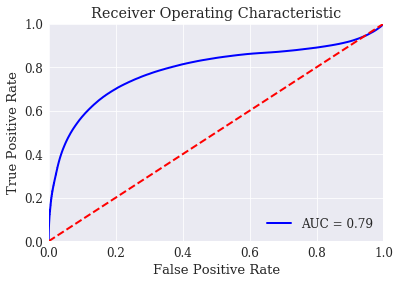

In [224]:
preds = pred_array
fpr, tpr, threshold = metrics.roc_curve(test_array, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()